In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')  

In [2]:
df = pd.read_csv(os.path.join("Dataset", "jaypee_metadata.csv"))
df

,study_id,findings
0,TEST_nx1.jpg,False
1,TEST_nx10.jpg,False
2,TEST_nx11.jpg,False
3,TEST_nx12.jpg,False
4,TEST_nx13.jpg,False
...,...,...
150,TRAIN_px52.jpg,Tuberculosis
151,TRAIN_px6.jpg,Tuberculosis
152,TRAIN_px7.jpg,Tuberculosis
153,TRAIN_px8.jpg,Tuberculosis


In [3]:
value = {"False" : 0, "Tuberculosis" : 1}
df["findings"] = df["findings"].map(value)
df

,study_id,findings
0,TEST_nx1.jpg,0
1,TEST_nx10.jpg,0
2,TEST_nx11.jpg,0
3,TEST_nx12.jpg,0
4,TEST_nx13.jpg,0
...,...,...
150,TRAIN_px52.jpg,1
151,TRAIN_px6.jpg,1
152,TRAIN_px7.jpg,1
153,TRAIN_px8.jpg,1


In [4]:
# for i, j in df.iterrows():
#     study_id = j["study_id"]
#     findings = j["findings"]
#     print(study_id, findings)
dffalse = df[df["findings"] == 0]
dftrue = df[df["findings"] == 1]

In [5]:
dffalse

,study_id,findings
0,TEST_nx1.jpg,0
1,TEST_nx10.jpg,0
2,TEST_nx11.jpg,0
3,TEST_nx12.jpg,0
4,TEST_nx13.jpg,0
...,...,...
98,TRAIN_nx51.jpg,0
99,TRAIN_nx6.jpg,0
100,TRAIN_nx7.jpg,0
101,TRAIN_nx8.jpg,0


In [6]:
dftrue

,study_id,findings
26,TEST_px27.jpg,1
27,TEST_px28.jpg,1
28,TEST_px29.jpg,1
29,TEST_px30.jpg,1
30,TEST_px31.jpg,1
...,...,...
150,TRAIN_px52.jpg,1
151,TRAIN_px6.jpg,1
152,TRAIN_px7.jpg,1
153,TRAIN_px8.jpg,1


In [7]:
imagesDir = os.path.join("Dataset", "images")
all_classes = ["normal", "tuberculosis"]

In [8]:
def createTrain(trainDir, all_classes:list, dfs:dict):
    for individual_class in all_classes:
        destDir = os.path.join(trainDir, individual_class)
        # print(destDir)
        if not os.path.exists(destDir):
            os.makedirs(destDir)
        else:
            print("Directory exists")
            return
        for i in dfs[individual_class].values:
            # print(i[0])
            srcDir = os.path.join(imagesDir, i[0])
            movetoDir = os.path.join(destDir)
            shutil.copy(srcDir, movetoDir)

In [9]:
createTrain(os.path.join("Dataset", "train"), all_classes, {"normal" : dffalse, "tuberculosis" : dftrue})

Directory exists


In [10]:
def createTest(classes:list):
    for i in classes:
        # print(i)
        trainDir = os.path.join("Dataset", "train", i)
        images = os.listdir(trainDir)
        images = random.sample(images, 15)
        destDir = os.path.join("Dataset", "test", i)
        images = [os.path.join(trainDir, img) for img in images]
        # print(images)
        if not os.path.exists(destDir):
            os.makedirs(destDir)
        else:
            print(f"Directory exists")
            return
        
        for img in images:
            shutil.move(img, destDir)
        

In [11]:
createTest(all_classes)

Directory exists


In [12]:
# train_transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(size=(224, 224)),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(size=(224, 224)),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [13]:
class CustomTransform:
    def __init__(self, size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], horizontal_flip=True):
        self.size = size
        self.mean = np.array(mean).reshape(3, 1, 1).astype(np.float32)
        self.std = np.array(std).reshape(3, 1, 1).astype(np.float32)
        self.horizontal_flip = horizontal_flip

    def resize(self, img):
        """Resize the image to the specified size."""
        return img.resize(self.size, Image.BILINEAR)

    def random_horizontal_flip(self, img):
        """Randomly flip the image horizontally."""
        if self.horizontal_flip and random.random() > 0.5:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

    def to_numpy_array(self, img):
        """Convert a PIL Image to a numpy array in float32 format and scale pixel values to [0, 1]."""
        img_array = np.array(img).astype(np.float32) / 255.0
        return img_array.transpose((2, 0, 1))  # Change HWC to CHW

    def normalize(self, array):
        """Normalize a numpy array image with mean and standard deviation."""
        return (array - self.mean) / self.std

    def __call__(self, img):
        """Apply all transformations in sequence to the image."""
        img = self.resize(img)
        img = self.random_horizontal_flip(img)
        img_array = self.to_numpy_array(img)
        return self.normalize(img_array).astype(np.float32)

In [14]:
train_transform = CustomTransform(horizontal_flip=True)
test_transform = CustomTransform(horizontal_flip=False)

In [15]:
class datasetCreation(torch.utils.data.Dataset):
    def __init__(self, imageDir: str, transform : CustomTransform, all_classes: list):
        def get_image(individual_class):
            images = os.listdir(os.path.join(imageDir, individual_class))
            return images
        
        self.images_dict = {}
        self.transform = transform
        self.all_classes = all_classes
        self.imageDir = imageDir
        
        for i in self.all_classes:
            self.images_dict[i] = get_image(i)
        
        print(self.images_dict)
        
    def __len__(self):
        return sum([len(self.images_dict[i]) for i in self.all_classes])
    
    def __getitem__(self, idx):
        individual_class = random.choice(self.all_classes)
        idx = idx % len(self.images_dict[individual_class]) # To keep the index inside the length of the list of images in individual class
        imagename = self.images_dict[individual_class][idx]
        imagepath = os.path.join(self.imageDir, individual_class, imagename)
        image = Image.open(imagepath).convert('RGB')
        return self.transform(image), self.all_classes.index(individual_class)

In [16]:
trainDataset = datasetCreation(os.path.join("Dataset", "train"), train_transform, all_classes)
testDataset = datasetCreation(os.path.join("Dataset", "test"), test_transform, all_classes)

{'normal': ['TEST_nx1.jpg', 'TEST_nx10.jpg', 'TEST_nx11.jpg', 'TEST_nx12.jpg', 'TEST_nx13.jpg', 'TEST_nx14.jpg', 'TEST_nx15.jpg', 'TEST_nx16.jpg', 'TEST_nx17.jpg', 'TEST_nx18.jpg', 'TEST_nx19.jpg', 'TEST_nx2.jpg', 'TEST_nx20.jpg', 'TEST_nx21.jpg', 'TEST_nx22.jpg', 'TEST_nx23.jpg', 'TEST_nx24.jpg', 'TEST_nx25.jpg', 'TEST_nx26.jpg', 'TEST_nx3.jpg', 'TEST_nx4.jpg', 'TEST_nx5.jpg', 'TEST_nx6.jpg', 'TEST_nx7.jpg', 'TEST_nx8.jpg', 'TEST_nx9.jpg', 'TRAIN_nx1.jpg', 'TRAIN_nx10.jpg', 'TRAIN_nx11.jpg', 'TRAIN_nx12.jpg', 'TRAIN_nx13.jpg', 'TRAIN_nx14.jpg', 'TRAIN_nx15.jpg', 'TRAIN_nx16.jpg', 'TRAIN_nx17.jpg', 'TRAIN_nx18.jpg', 'TRAIN_nx19.jpg', 'TRAIN_nx2.jpg', 'TRAIN_nx20.jpg', 'TRAIN_nx21.jpg', 'TRAIN_nx22.jpg', 'TRAIN_nx23.jpg', 'TRAIN_nx24.jpg', 'TRAIN_nx25.jpg', 'TRAIN_nx26.jpg', 'TRAIN_nx27.jpg', 'TRAIN_nx28.jpg', 'TRAIN_nx29.jpg', 'TRAIN_nx3.jpg', 'TRAIN_nx30.jpg', 'TRAIN_nx31.jpg', 'TRAIN_nx32.jpg', 'TRAIN_nx33.jpg', 'TRAIN_nx34.jpg', 'TRAIN_nx35.jpg', 'TRAIN_nx36.jpg', 'TRAIN_nx37.jpg', 

In [17]:
batch_size = 4

dl_train = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(testDataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 39
Number of test batches 8


In [18]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [20]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{all_classes[int(labels[i].numpy())]}')
        plt.ylabel(f'{all_classes[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [21]:
def show_preds():
    resnet18.eval() # set to evaluation mode
    images, labels = next(iter(dl_test))
    # print(images, labels)
    outputs = resnet18(images) 
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

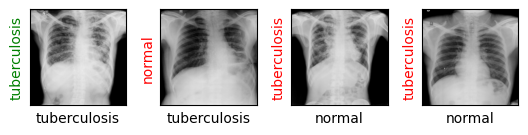

In [22]:
show_preds()

In [23]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(testDataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/20
Evaluating at step 0
Validation Loss: 0.7116, Accuracy: 0.6000


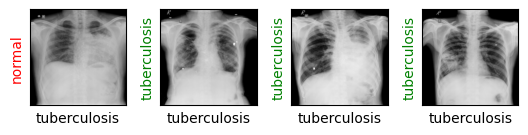

Evaluating at step 20
Validation Loss: 0.6293, Accuracy: 0.8667


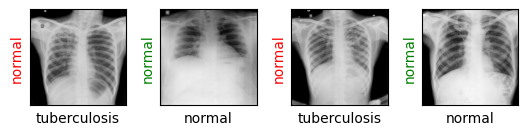

Training Loss: 0.5723
Starting epoch 2/20
Evaluating at step 0
Validation Loss: 0.4748, Accuracy: 0.7667


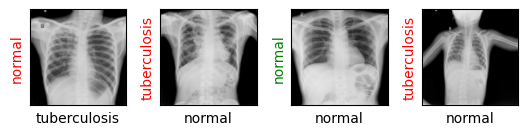

Evaluating at step 20
Validation Loss: 0.3790, Accuracy: 0.9000


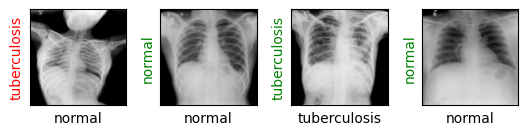

Training Loss: 0.4428
Starting epoch 3/20
Evaluating at step 0
Validation Loss: 0.2829, Accuracy: 0.8333


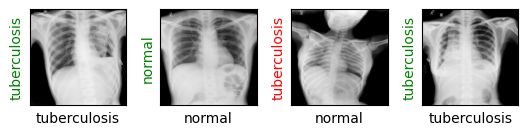

Evaluating at step 20
Validation Loss: 0.2633, Accuracy: 0.8667


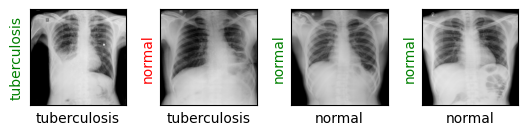

Training Loss: 0.2853
Starting epoch 4/20
Evaluating at step 0
Validation Loss: 0.2237, Accuracy: 0.9000


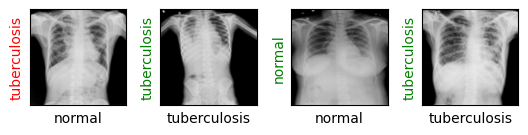

Evaluating at step 20
Validation Loss: 0.1448, Accuracy: 0.9667


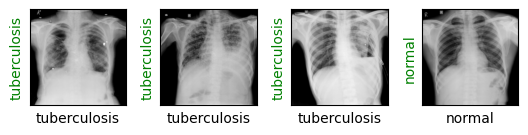

Training Loss: 0.2517
Starting epoch 5/20
Evaluating at step 0
Validation Loss: 0.1337, Accuracy: 1.0000


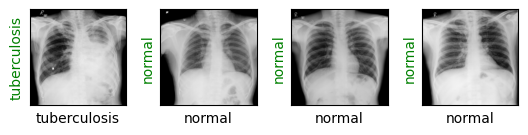

Performance condition satisfied, stopping..


In [24]:
train(epochs=20)

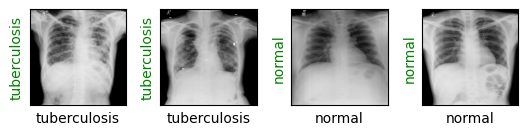

In [25]:
show_preds()

In [27]:
resnet18.eval()
random_input = torch.randn(1,3,224,224)
onnx_output_path = "tuberculosisModel.onnx"
torch.onnx.export(
    resnet18,
    random_input,
    onnx_output_path,
    export_params=True,        # Store the trained parameter weights inside the model file
              # Specify the ONNX version
    do_constant_folding=True,  # Simplify the model by folding constant nodes
    input_names=['input'],     # Define input layer name
    output_names=['output']    # Define output layer name
)